In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import calendar
from math import sqrt
from pandas import datetime
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [6]:
cocacola=pd.read_excel('/content/CocaCola_Sales_Rawdata  Forecasting.xlsx')
cocacola

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [7]:
cocacola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [8]:
cocacola.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [9]:
print('Shape of the data :',cocacola.shape)

Shape of the data : (42, 2)


In [10]:
cocacola.dtypes

Quarter     object
Sales      float64
dtype: object

In [11]:
cocacola.nunique()

Quarter    42
Sales      42
dtype: int64

In [12]:
cocacola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [13]:
cocacola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


## Feature Engineering

In [14]:
cocacola['Quarter_Year'] = cocacola['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

cocacola.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [15]:
cocacola['Date'] = (pd.to_datetime(cocacola['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
cocacola.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


## Extracting the Quarters and putting in column

In [16]:
cocacola['Quarters'] = 0

for i in range(42):
    n =cocacola['Quarter'][i]
    cocacola['Quarters'][i] = n[0:2]

cocacola.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [17]:
dummy = pd.DataFrame(pd.get_dummies(cocacola['Quarters']))
df = pd.concat((cocacola, dummy), axis=1)

df.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [18]:
df.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [19]:
df.set_index('Date',inplace=True)
df.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [20]:
df.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [21]:
cocacola["Date"] = pd.to_datetime(cocacola.Date,format="%b-%y")
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
cocacola.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


## Data Visualization

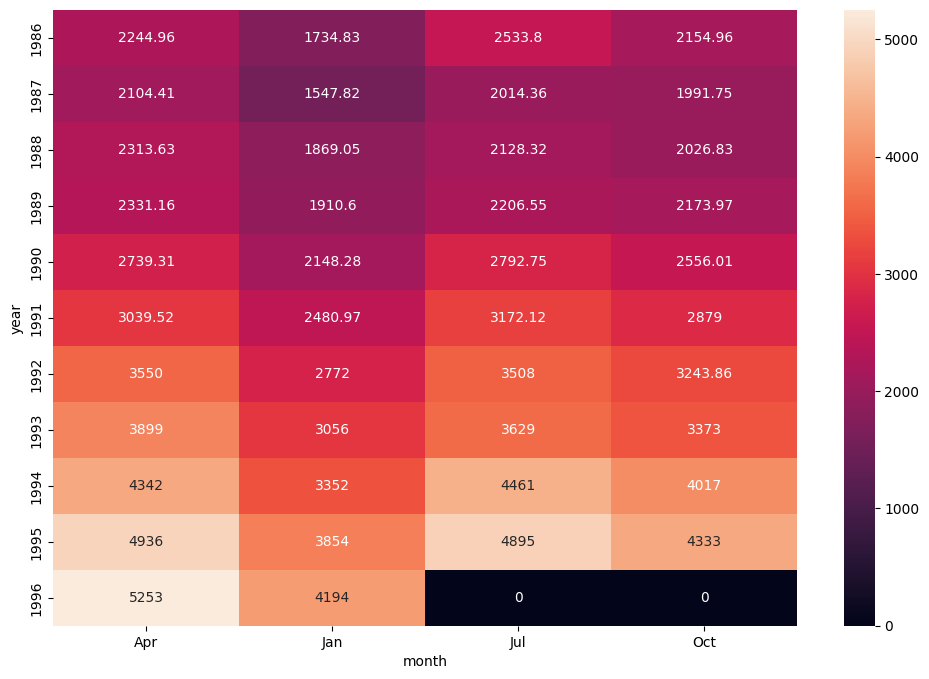

In [22]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=cocacola, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

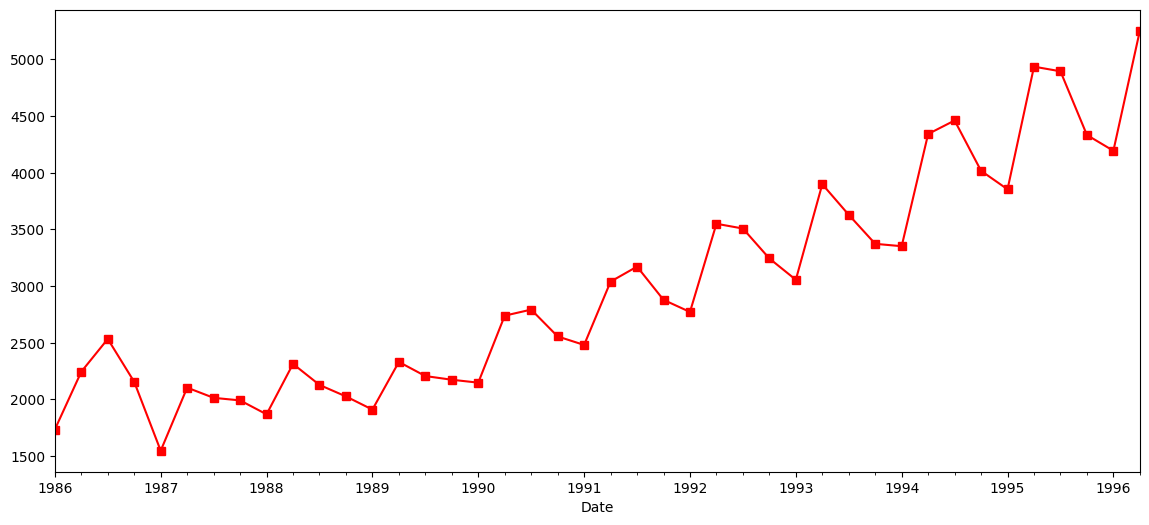

In [23]:
df['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

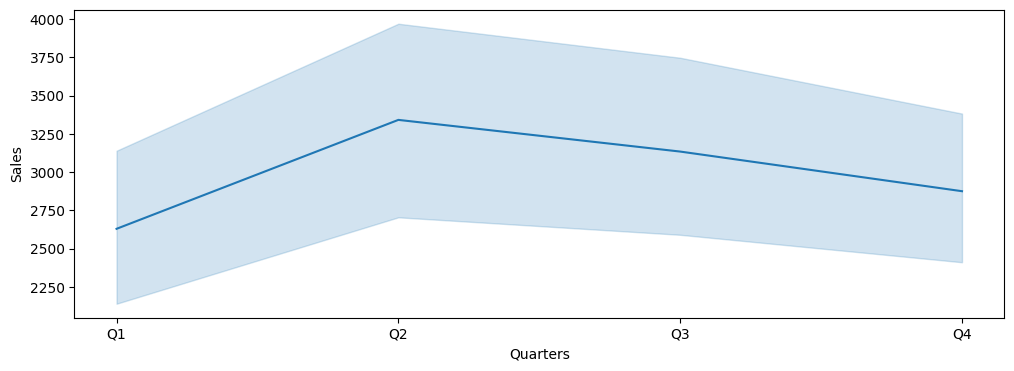

In [24]:
plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=cocacola)
plt.show()

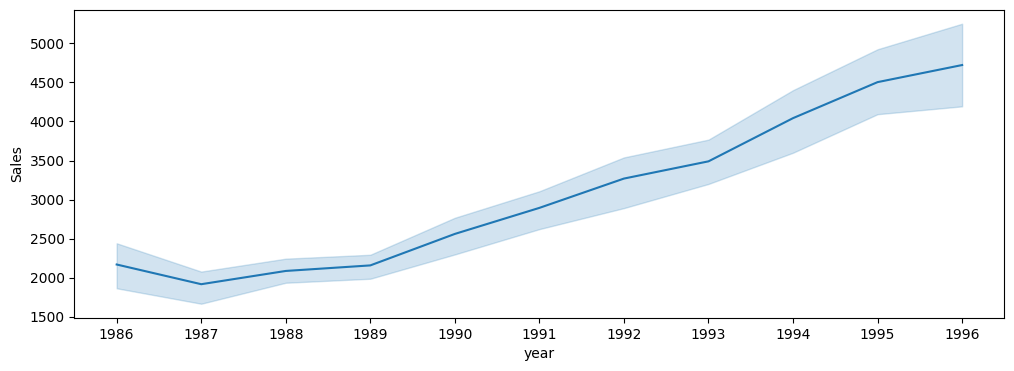

In [25]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=cocacola)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

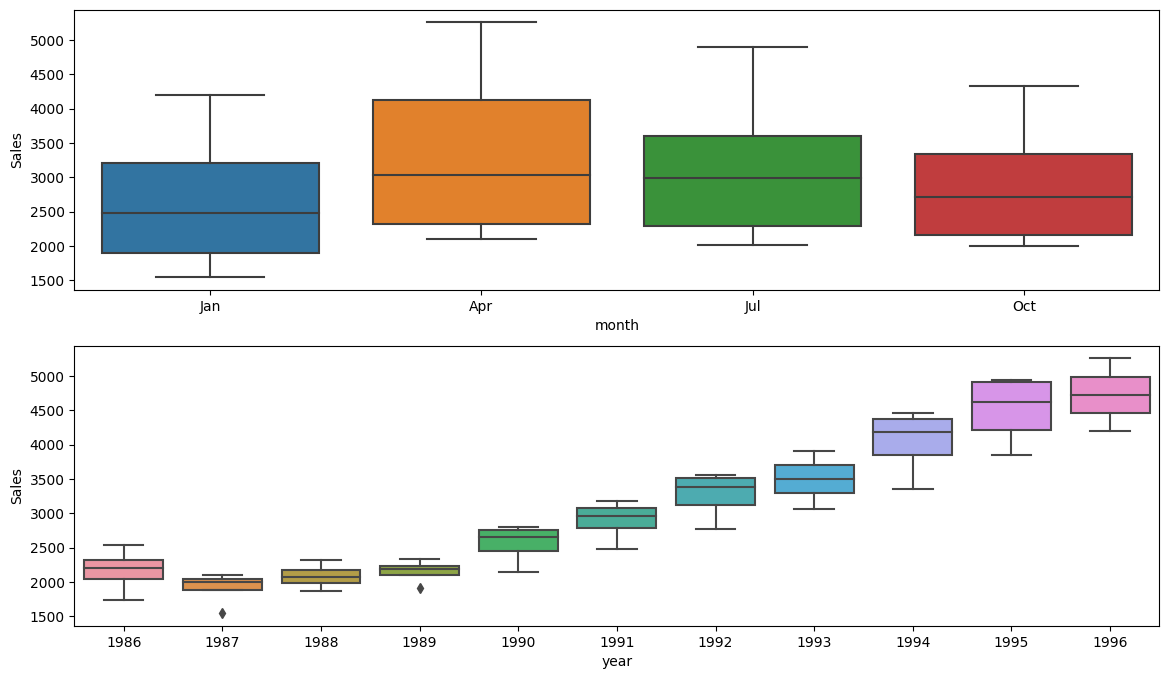

In [26]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=cocacola)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=cocacola)
plt.show()

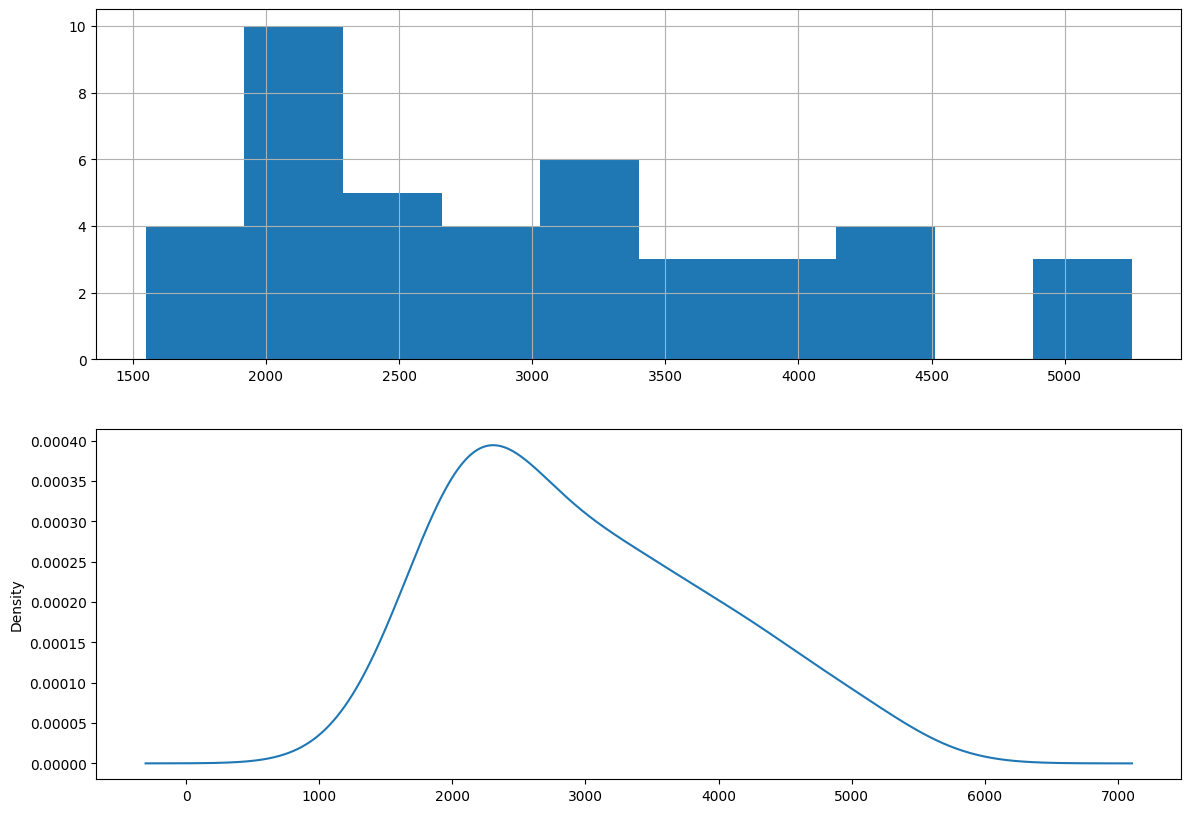

In [28]:
plt.figure(figsize=(14,10))
plt.subplot(211)
cocacola.Sales.hist()
plt.subplot(212)
cocacola.Sales.plot(kind='kde')
plt.show()

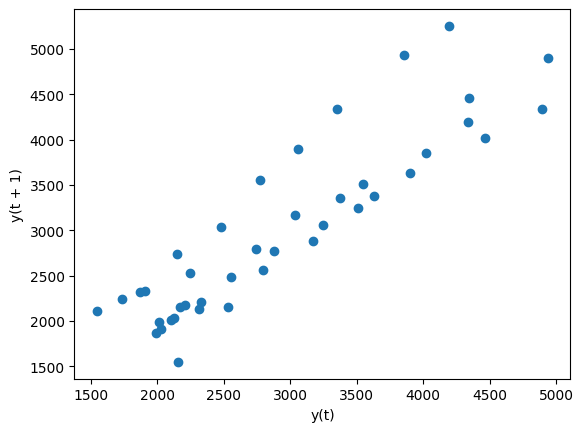

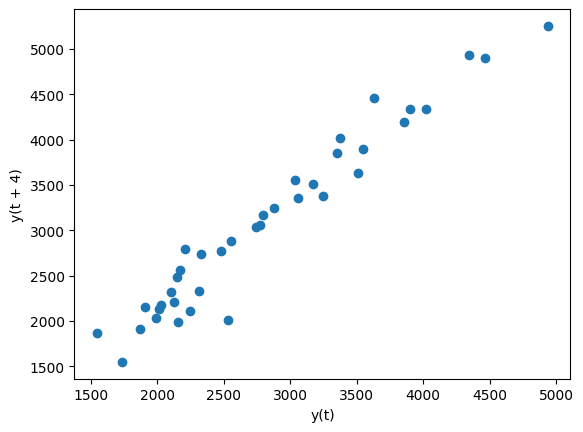

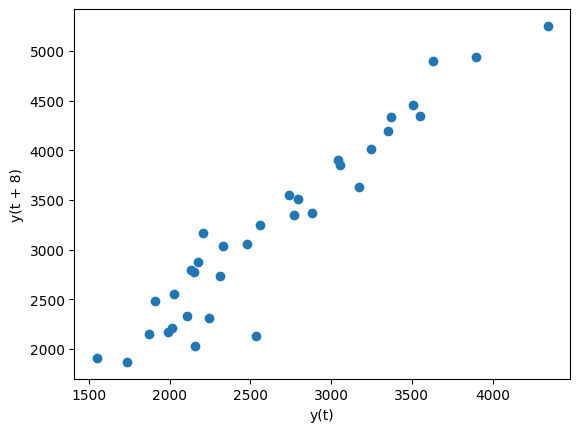

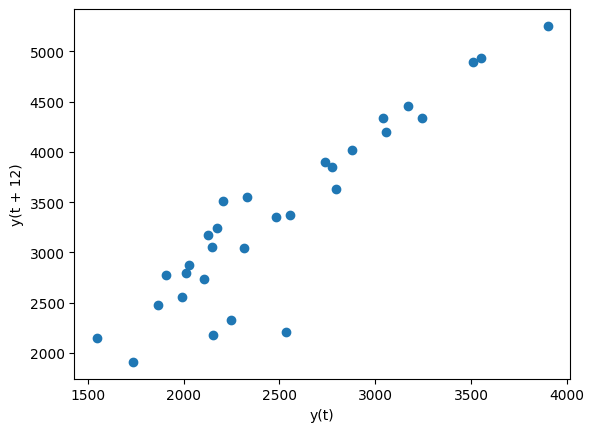

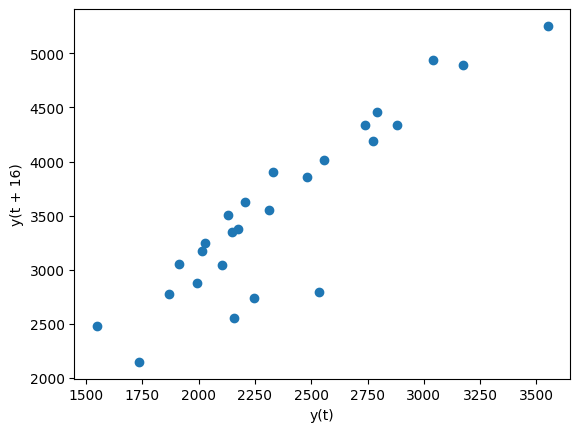

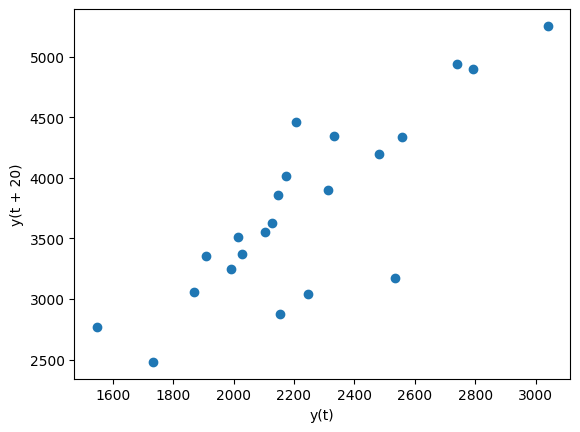

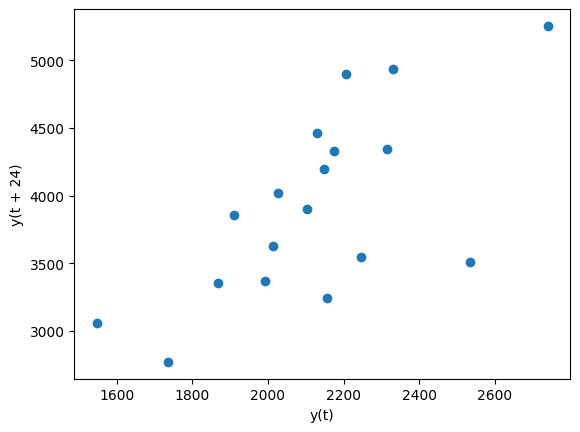

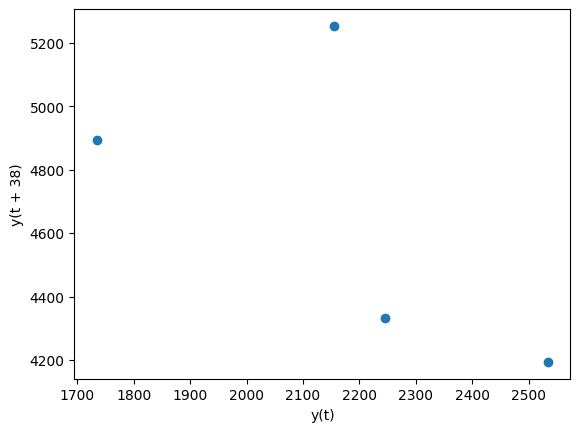

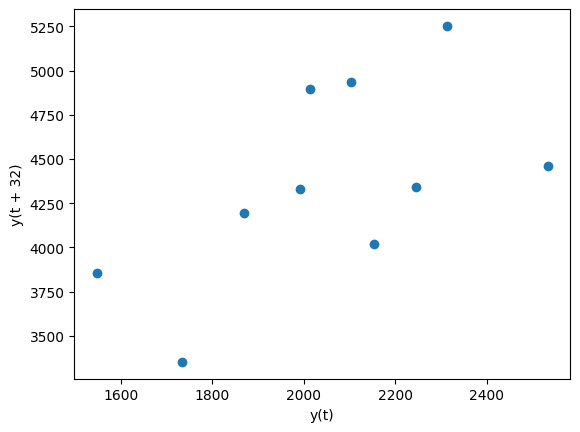

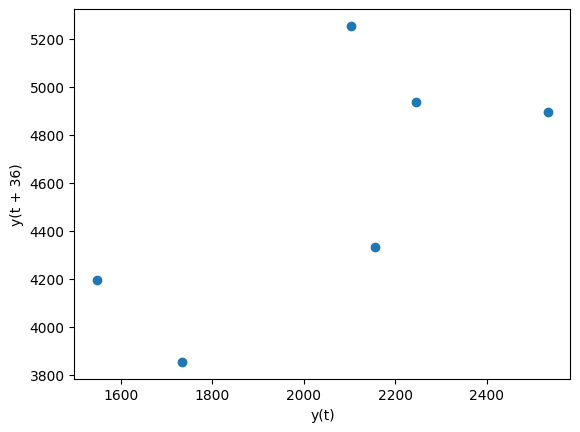

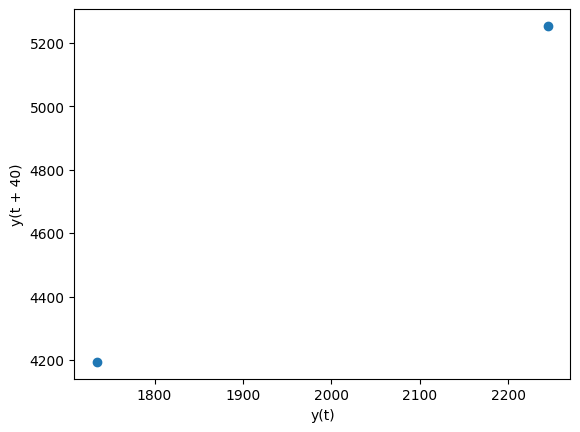

In [29]:
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    lag_plot(df.Sales, lag=i)
    plt.show()

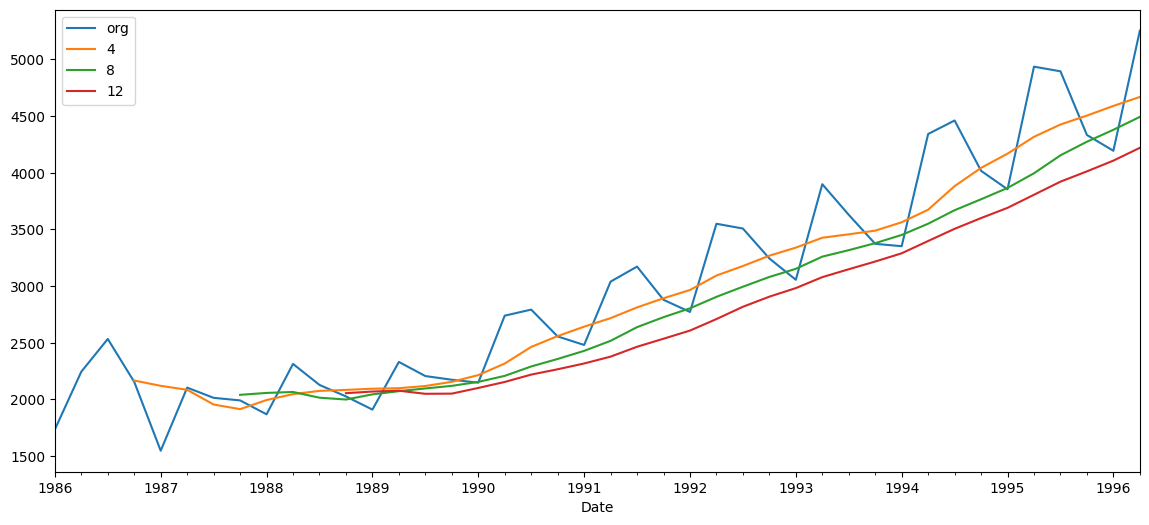

In [30]:
plt.figure(figsize=(14,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

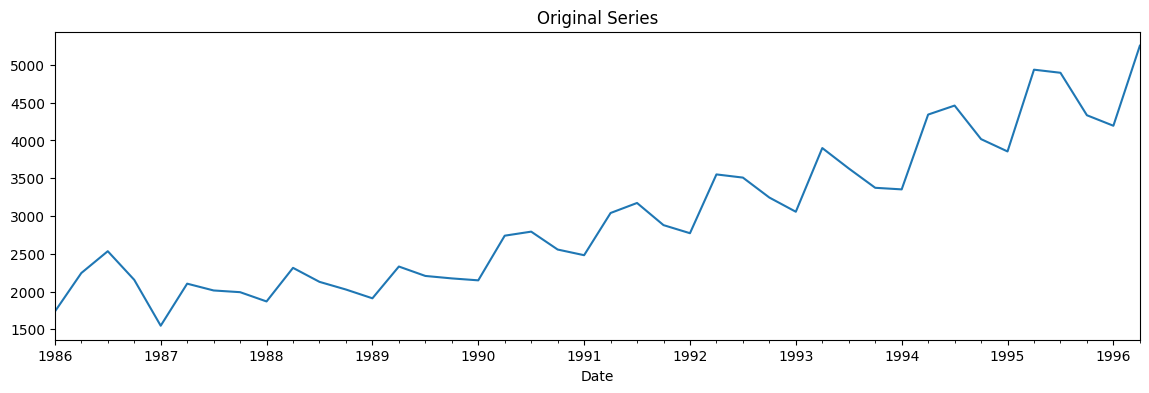

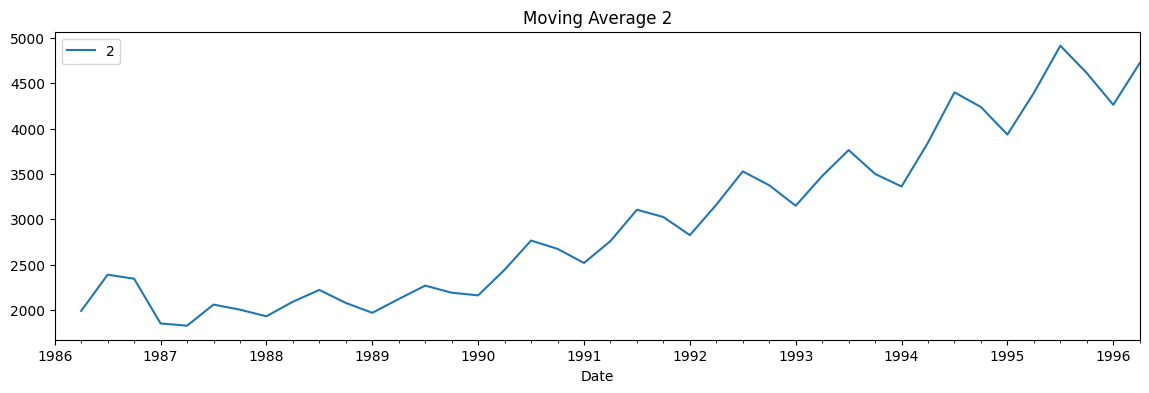

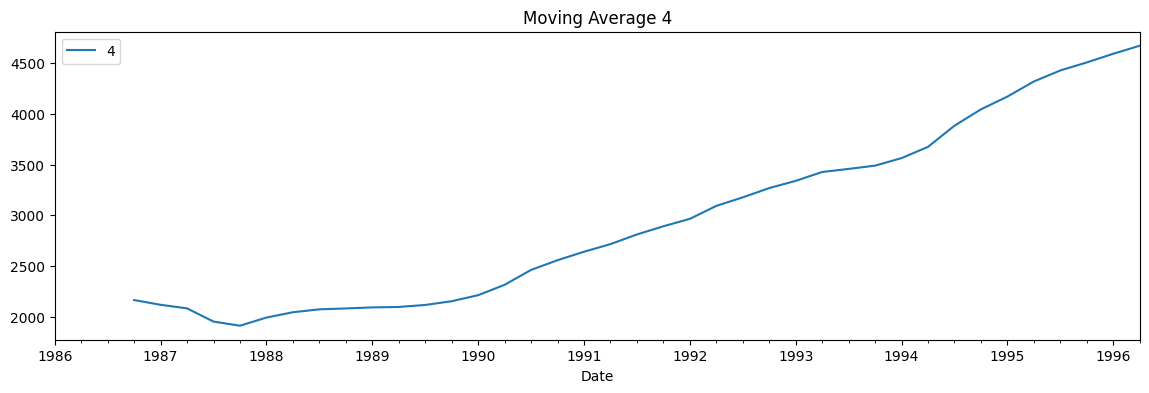

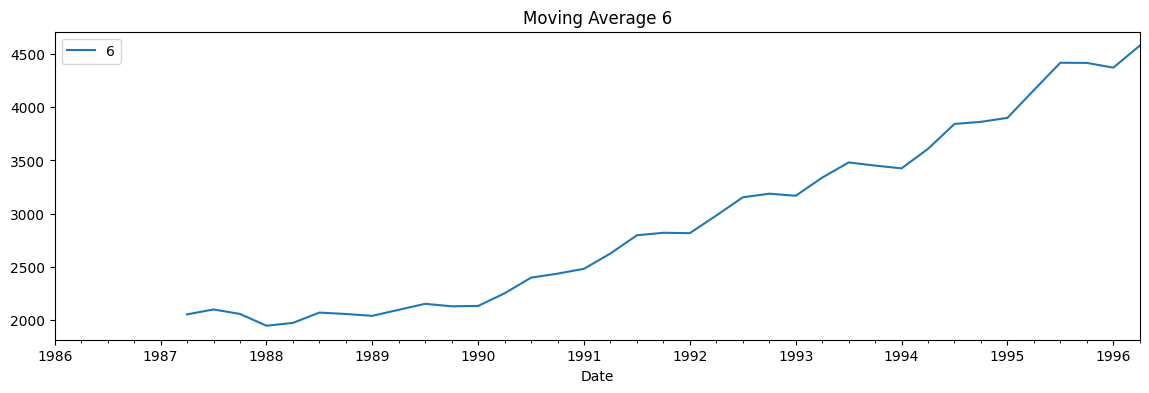

In [31]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,7,2):
    plt.figure(figsize=(14,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

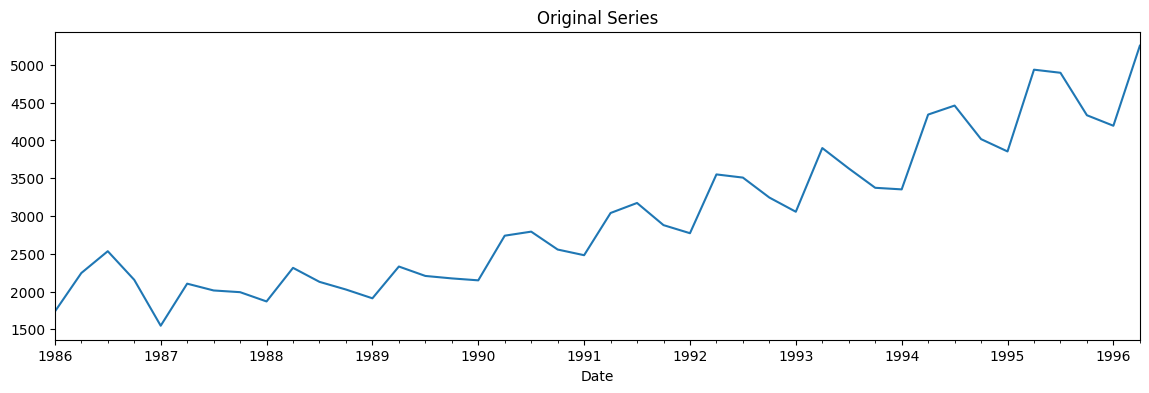

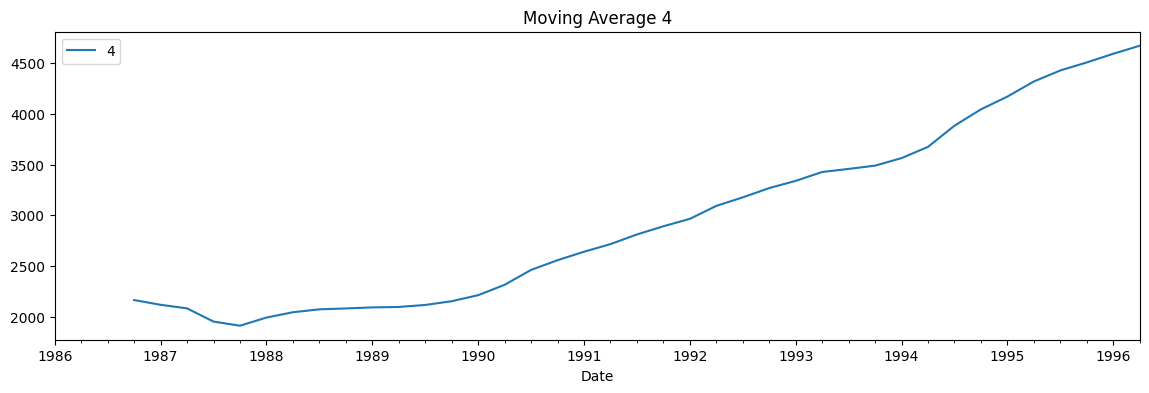

In [32]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

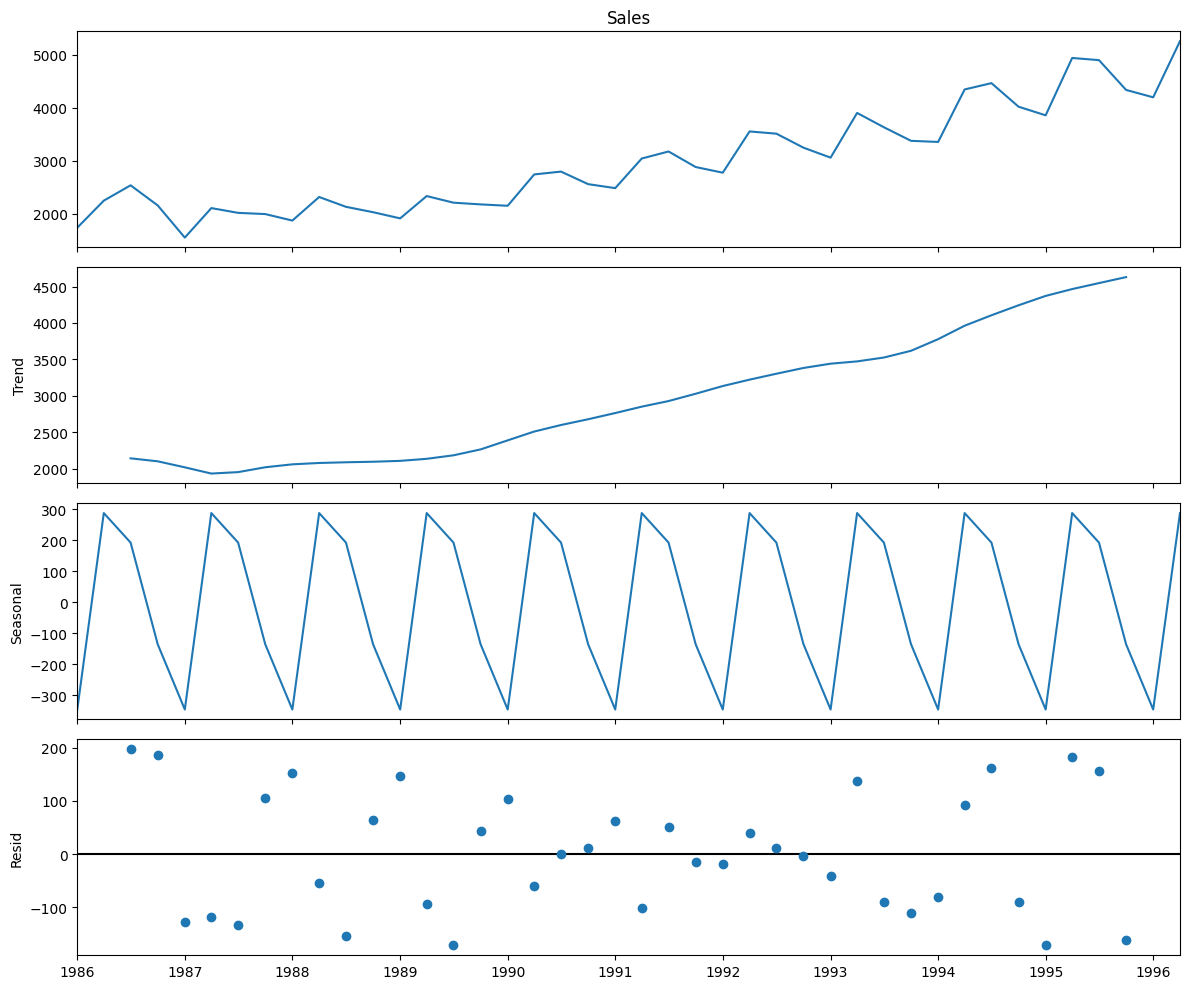

In [33]:
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

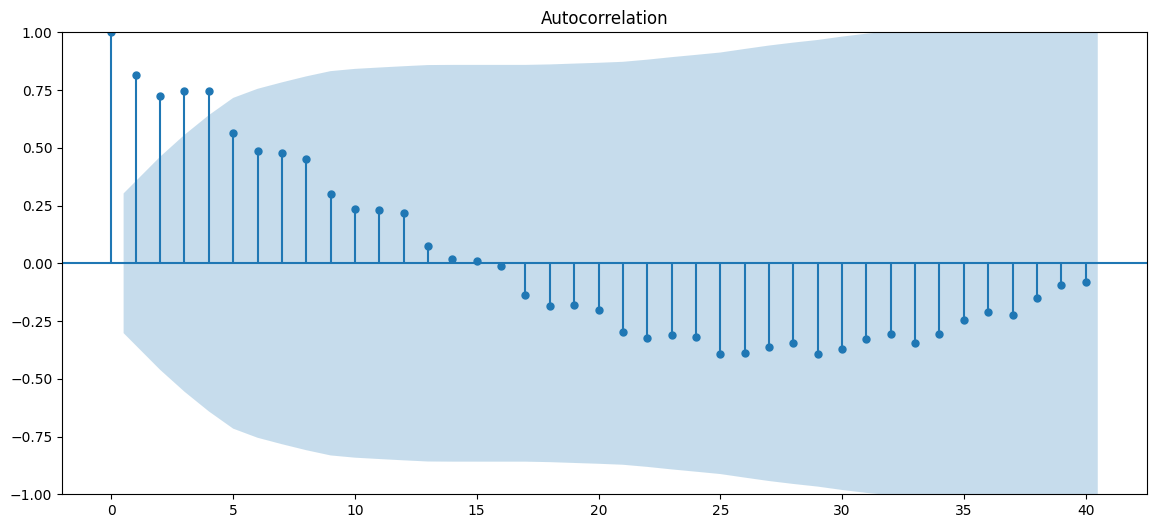

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Sales,lags=40)
    plt.show()

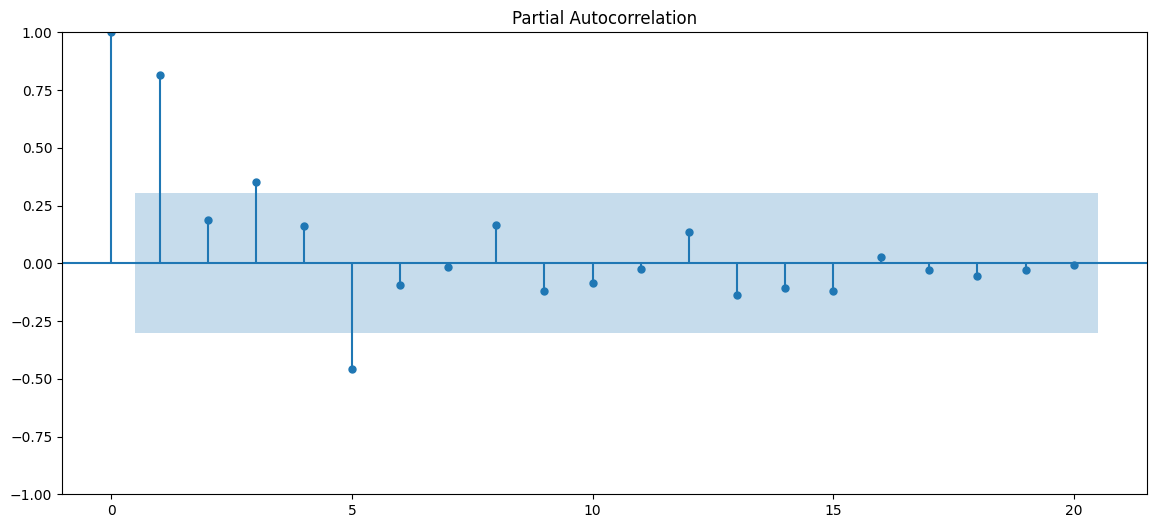

In [35]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [38]:
upsampled_month = df.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996


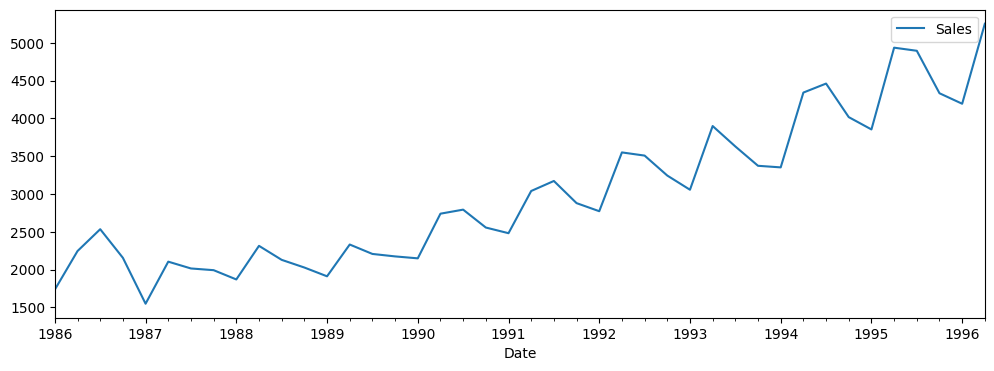

In [39]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(13))
interpolated_month.plot(figsize=(12,4))
plt.show()

In [40]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


### Time Series Decomposition
1. Seasonality
2. Trend

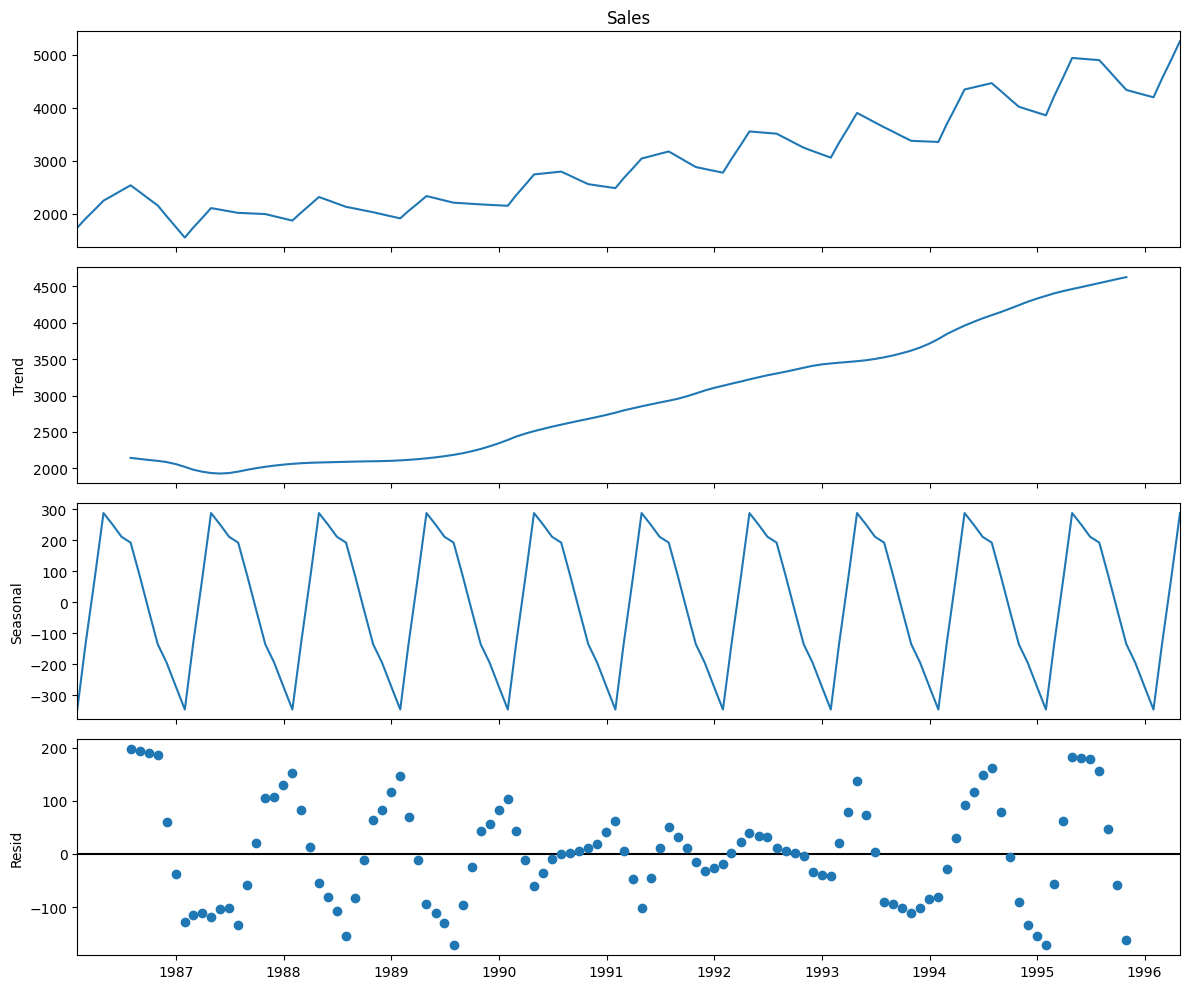

In [41]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

In [42]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]
print('Train :',train_data.index.min(),train_data.index.max(),'\n',
'Test :',test_data.index.min(),test_data.index.max())

Train : 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test : 1994-05-31 00:00:00 1996-04-30 00:00:00


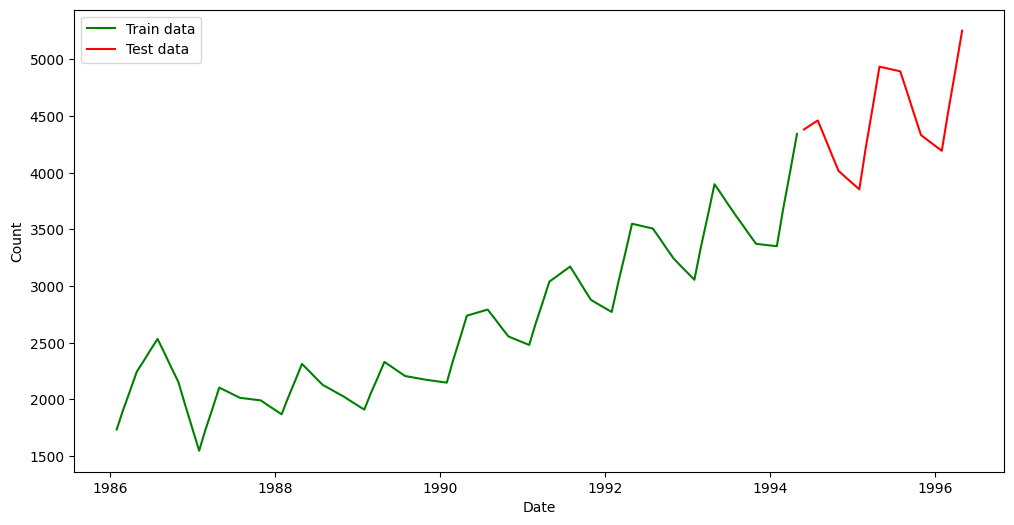

In [43]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

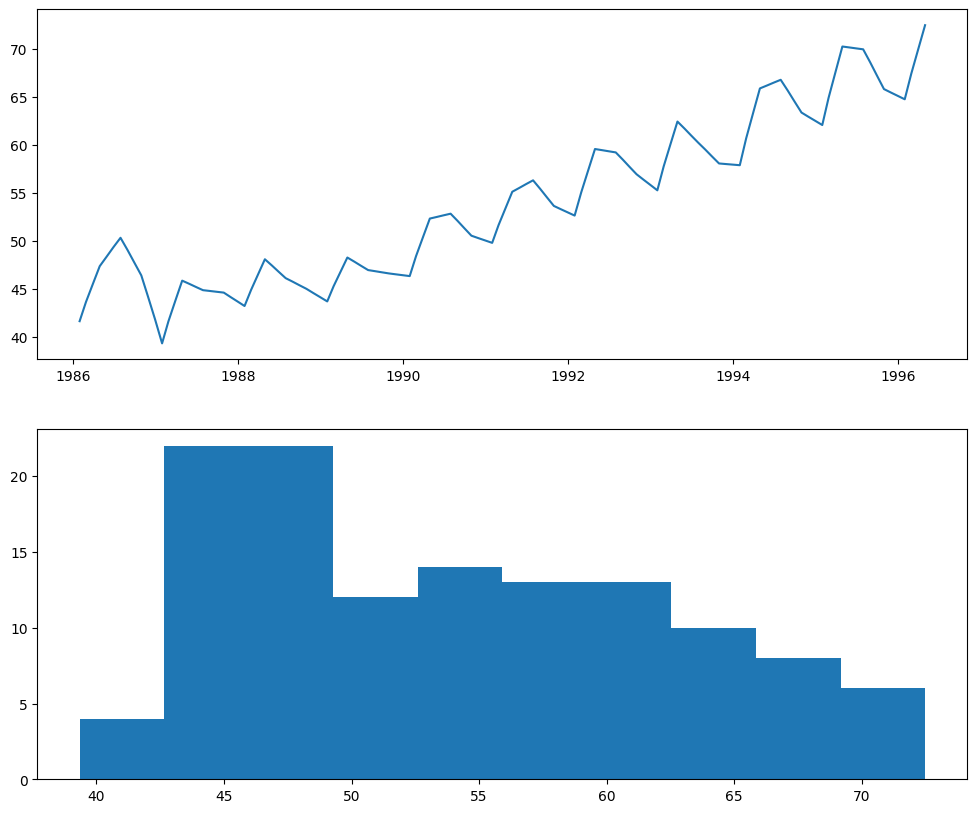

In [48]:
square_root = pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

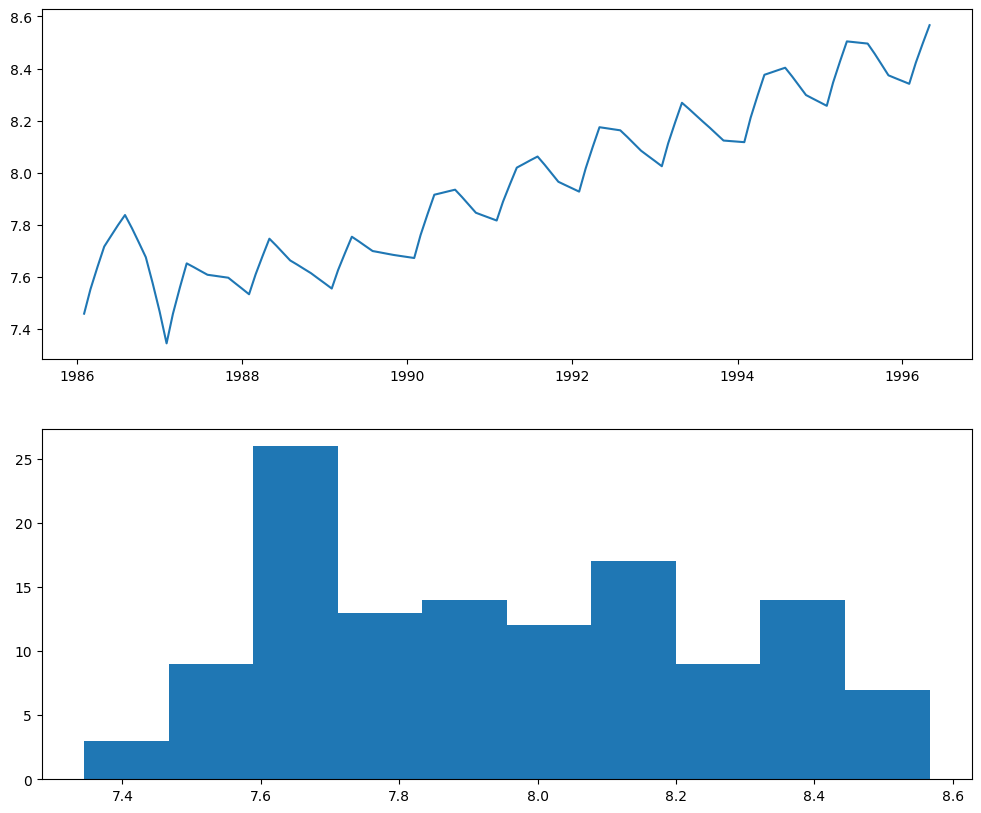

In [44]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])

# Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


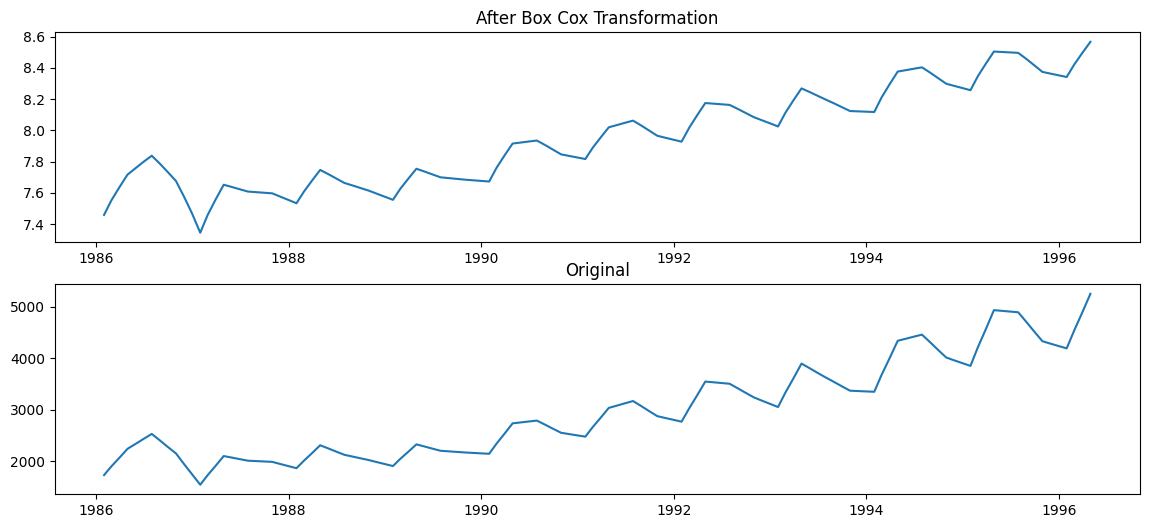

In [50]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

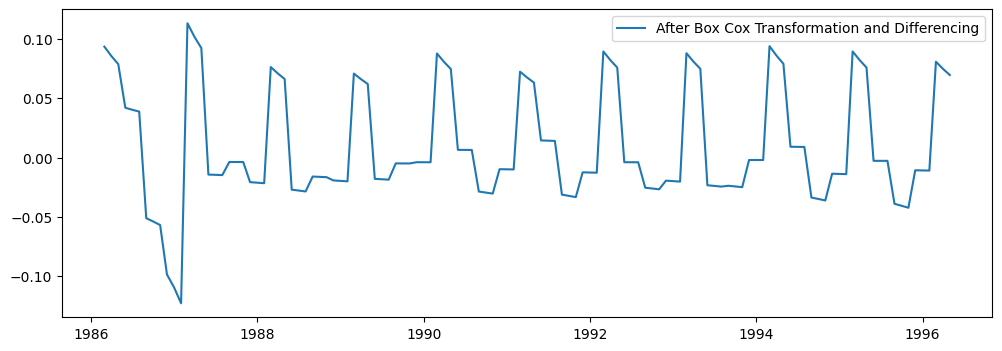

In [52]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [53]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

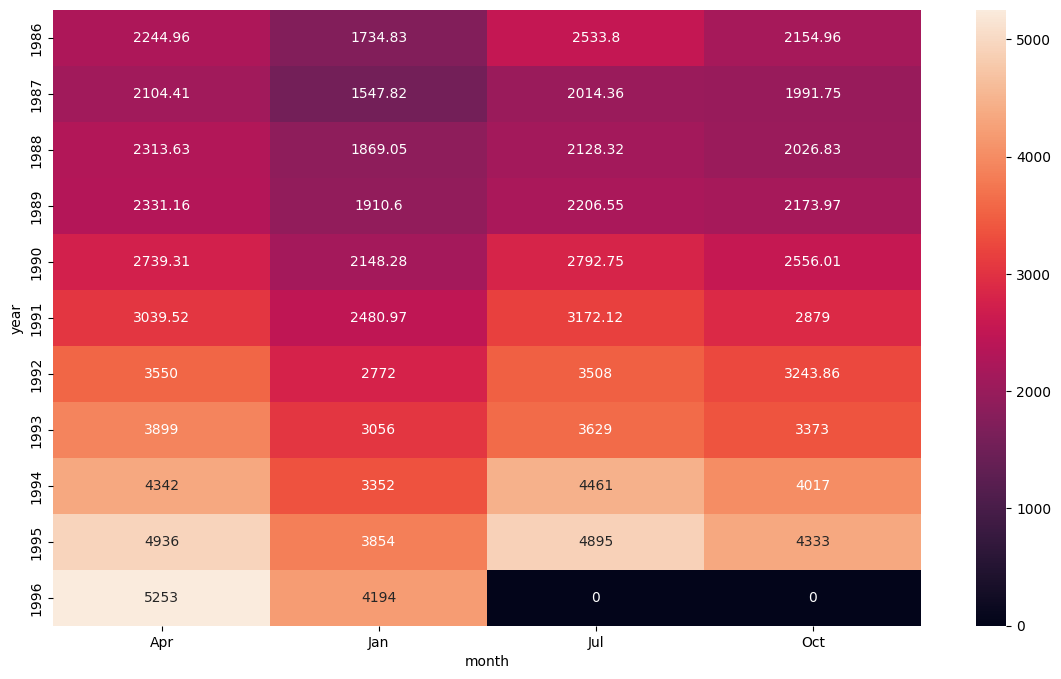

In [54]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

In [59]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [60]:
train_data

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988
